Study of following gist code which convert TensorFlow Quantum's MNIST tutorial to blueqat+pytorch code.  
https://gist.github.com/gyu-don/f7af13e32f9b18010c75ffdb825f97f0

Some changes was applied.
- Using only non-contradictory examples (4613) to train model for time saving.
- Using BCE loss function instead of Hinge. It results in faster loss decreasing in early phase of learning.
- Learning rate is adjusted (from 0.001 to 0.1). It still works.
- Another method is proposed to evaluate prediction for test samples

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import collections
from blueqat import Circuit, BlueqatGlobalSetting
from blueqat.pauli import I, X, Y, Z
import torch
import torchvision

In [2]:
import random
import time

In [3]:
from blueqat import BlueqatGlobalSetting
BlueqatGlobalSetting.set_default_backend('numba')

In [4]:
params = np.random.rand(32)

start = time.time()
c = Circuit()
c.x[16].h[16]
for i in range(16):
    c.rxx(params[i])[16, i]
for i in range(16):
    c.rzz(params[i + 16])[16, i]
c.h[16]
time1 = time.time()
print('build time: ', time1 - start)

print(c.run())
time2 = time.time()
print('run time: ', time2 - time1)

build time:  0.0009379386901855469
[ 0.00000000e+00+4.44249759e-01j  1.53392392e-02+0.00000000e+00j
 -1.78818064e-01+0.00000000e+00j ...  0.00000000e+00+7.11840862e-14j
  0.00000000e+00+1.45509910e-13j -3.04772335e-14+0.00000000e+00j]
run time:  3.2425038814544678


In [5]:
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize([4, 4]),
                                   torchvision.transforms.ToTensor()]))
test_data = torchvision.datasets.MNIST('./data', train=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize([4, 4]),
                                   torchvision.transforms.ToTensor()]))

In [6]:
train_indices = [i for i, (_, y) in enumerate(train_data) if y in (3, 6)]
test_indices = [i for i, (_, y) in enumerate(test_data) if y in (3, 6)]

In [7]:
train_data = torch.utils.data.Subset(train_data, train_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

3


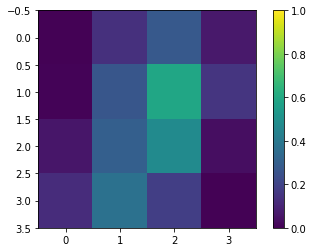

In [8]:
print(train_data[0][1])
plt.imshow(train_data[0][0][0].numpy(), vmin=0, vmax=1); plt.colorbar()

In [9]:
# From TFQ.
def remove_contradicting(dataset):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x, y in dataset:
        mapping[tuple(x.flatten().numpy())].add(int(y))
    new_dataset = []
    new_x = []
    new_y = []
    for x, y in dataset:
        labels = mapping[tuple(x.flatten().numpy())]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(list(labels)[0])
            new_dataset.append((x, list(labels)[0]))
        else:
            # Throw out images that match more than one label.
            pass
    
    num_3 = sum(1 for value in mapping.values() if 3 in value or 1 in value)
    num_6 = sum(1 for value in mapping.values() if 6 in value or -1 in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(dataset))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    return new_dataset

In [10]:
new_train_data = remove_contradicting(train_data)

Number of unique images: 12049
Number of 3s:  6131
Number of 6s:  5918
Number of contradictory images:  0

Initial number of examples:  12049
Remaining non-contradictory examples:  12049


In [11]:
THRESHOLD = 0.2
train_data_bin = torch.utils.data.TensorDataset(torch.cat([x > THRESHOLD for x, _ in train_data]), torch.tensor([1 if y == 3 else -1 for _, y in train_data]))
test_data_bin = torch.utils.data.TensorDataset(torch.cat([x > THRESHOLD for x, _ in test_data]), torch.tensor([1 if y == 3 else -1 for _, y in test_data]))

In [12]:
new_train_data_bin = remove_contradicting(train_data_bin)
len(new_train_data_bin)

Number of unique images: 315
Number of 3s:  215
Number of 6s:  154
Number of contradictory images:  54

Initial number of examples:  12049
Remaining non-contradictory examples:  4613


4613

In [13]:
def model_circuit(image, params):
    bits = tuple(image.detach().reshape(-1).numpy().nonzero()[0])
    c = Circuit()
    if bits:
        c.x[bits]
    c.x[16].h[16]
    params = tuple(params.detach().numpy())
    for i in range(16):
        c.rxx(params[i])[16, i]
    for i in range(16):
        c.rzz(params[i + 16])[16, i]
    c.h[16]
    return c

model_readout = Z[16]

In [12]:
# model_circuit(train_data_bin[0][0], torch.ones(32)).run_with_ibmq(returns='draw')

In [14]:
class GeneralFunctionWithForwardDifference(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f, xs, weight):
        def f_each(x, weight):
            return torch.tensor([f(x, weight) for x in xs], dtype=torch.float64)
        ys = f_each(xs, weight)
        ctx.save_for_backward(xs, ys, weight)
        ctx.f = f_each
        return ys
        
    @staticmethod
    def backward(ctx, grad_output):
        xs, ys, weight = ctx.saved_tensors
        dw = 0.001
        diff = []
        weight = weight.detach()
        for i in range(len(weight)):
            weight[i] += dw
            diff.append(torch.sum(grad_output * (ctx.f(xs, weight) - ys)))
            weight[i] -= dw
        diff = torch.tensor(diff) / dw
        #print("grad_output", grad_output, "end")
        #print(diff)
        return None, None, diff

In [15]:
from blueqat.vqe import sparse_expectation

class PQC(torch.nn.Module):
    def __init__(self, model_circuit, n_params, n_qubits, readout_operators, initial_circuit=None):
        super(PQC, self).__init__()
        if initial_circuit is None:
            initial_circuit = Circuit()
        initial_circuit.make_cache()
        self.initial_circuit = initial_circuit
        self.model_circuit = model_circuit
        self.readout_operators = readout_operators
        self.sparses = [op.to_matrix(n_qubits=n_qubits, sparse='csc') for op in readout_operators]
        self.weight = torch.nn.parameter.Parameter(torch.Tensor(n_params))
        torch.nn.init.uniform_(self.weight, 0.0, 2 * np.pi)
        
    def forward(self, x):
        def f(x, weight):
            c = self.initial_circuit.copy()
            c += self.model_circuit(x, self.weight)
            v = c.run()
            return [sparse_expectation(sparse, v) for sparse in self.sparses]
        return GeneralFunctionWithForwardDifference.apply(f, x, self.weight)

In [16]:
class HingeLoss(torch.nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
        self.loss = torch.nn.MarginRankingLoss(margin=1.)

    def forward(self, x, y):
        zeros = torch.zeros_like(x)
        return self.loss(x, zeros, y)
    
class BCELoss(torch.nn.Module):
    def __init__(self):
        super(BCELoss, self).__init__()
        self.loss = torch.nn.BCELoss()

    def forward(self, x, y):
        x = (x + 1.0) / 2.0
        y = (y + 1.0) / 2.0
        return self.loss(x, y)

In [17]:
def accuracy(xs, ys):
    xs = xs.detach()
    xs = xs > 0.
    ys = ys > 0.
    return torch.mean((xs == ys).float())

In [18]:
import bokeh
import bokeh.io
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
try:
    from bokeh.io import gridplot
except ImportError:
    from bokeh.layouts import gridplot

output_notebook()

Loading BokehJS ...

In [21]:
epochs = 1
batch_size = 32
x_range_max = len(new_train_data_bin) // batch_size + 2

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

Learning rate is changed to 0.1.  
Loss function is BCE.

In [22]:
from blueqat import BlueqatGlobalSetting
BlueqatGlobalSetting.set_default_backend('numba')

model = PQC(model_circuit, 32, 17, [model_readout])
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = BCELoss()

train_loader = torch.utils.data.DataLoader(new_train_data_bin, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_bin)

losshist_train = []; losshist_test = []
i = 0
for epoch in range(epochs):
    model.train()
    losses = []
    for im, label in train_loader:
        out = model(im)
        out = out.reshape(-1).float()
        loss = criterion(out, label)
        losses.append(loss.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = accuracy(out, label)
        update(i, float(torch.mean(loss.detach()).item()), float(acc.item()))
        i += 1
    losshist_train.append(torch.mean(torch.tensor(losses)).item())
    
    model.eval()
    losses = []
    for im, label in test_loader:
        out = model(im)
        out = out.reshape(-1).float()
        loss = criterion(out, label)
        losses.append(loss.detach())
    losshist_test.append(torch.mean(torch.tensor(losses)).item())
    
    update(epoch, losshist_train[-1], losshist_test[-1])

0 0.6927420496940613 0.625
1 0.6905896067619324 0.5625
2 0.6789793372154236 0.8125
3 0.6788825988769531 0.6875
4 0.6772722005844116 0.59375
5 0.6331669092178345 0.875
6 0.6059089303016663 0.71875
7 0.6039522290229797 0.59375
8 0.5224955081939697 0.75
9 0.5370877981185913 0.78125
10 0.6205060482025146 0.6875
11 0.4043888747692108 0.84375
12 0.4880523979663849 0.75
13 0.3730306029319763 0.8125
14 0.3463984727859497 0.9375
15 0.3339196443557739 0.875
16 0.21752774715423584 1.0
17 0.34162622690200806 0.875
18 0.31159308552742004 0.9375
19 0.3855045735836029 0.84375
20 0.19283664226531982 0.96875
21 0.22696363925933838 0.9375
22 0.2329559326171875 0.9375
23 0.30140742659568787 0.875
24 0.24434176087379456 0.8125
25 0.347586989402771 0.84375
26 0.3446471095085144 0.84375
27 0.3303515613079071 0.875
28 0.19201654195785522 0.9375
29 0.19665966928005219 0.9375
30 0.31803837418556213 0.8125
31 0.4038929045200348 0.875
32 0.12776805460453033 0.96875
33 0.20886395871639252 0.9375
34 0.282401114702

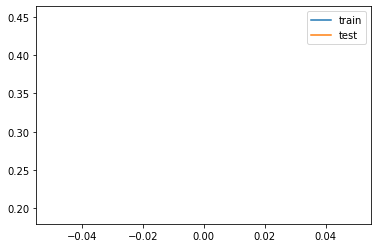

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(losshist_train, label='train')
plt.plot(losshist_test, label='test')
plt.legend()

In [26]:
torch.save(model.state_dict(), 'mnist_lr0.1_BCE.pytorch')

In [25]:
count = 0; tot = 0
for im, label in test_loader:
    model.eval()
    out = model(im)
    if (out.item() > 0.5) == (label.item() > 0.5):
        count += 1
    tot += 1
print(f'Test result: {count}/{tot} ({100 * count / tot} %)')

Test result: 1617/1968 (82.16463414634147 %)


## Another test

In above test, results such that {out=0.2, label=-1} is judged as validly predicted.  
However it should be judged as incorrect, so I made another test function.

In [30]:
count = 0; tot = 0
THRESHOLD = 0.
for im, label in test_loader:
    model.eval()
    out = model(im)
    if (out.item() > THRESHOLD) and (label.item() > THRESHOLD):
        count += 1
    elif (out.item() < -THRESHOLD) and (label.item() < -THRESHOLD):
        count += 1
    tot += 1
print(f'Test result: {count}/{tot} ({100 * count / tot} %)')

Test result: 1411/1968 (71.69715447154472 %)


### Classical NN

In [ ]:
relu = torch.nn.functional.relu
tanh = torch.nn.functional.tanh
class ClassicalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(16, 8)
        self.fc2 = torch.nn.Linear(8, 4)
        self.fc3 = torch.nn.Linear(4, 1)
    def forward(self, x):
        x = x.reshape(-1, 16)
        x = relu(self.fc1(x.float()))
        x = relu(self.fc2(x))
        x = tanh(self.fc3(x))
        return x

In [ ]:
epochs = 3
c_batch_size = 32
x_range_max = epochs + 1

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

In [ ]:
relu = torch.nn.functional.relu
tanh = torch.nn.functional.tanh
class TinyClassicalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(16, 2)
        self.fc2 = torch.nn.Linear(2, 1)
    def forward(self, x):
        x = x.reshape(-1, 16)
        x = relu(self.fc1(x.float()))
        x = tanh(self.fc2(x.float()))
        return x

In [ ]:
tiny_model = TinyClassicalModel()
sum(p.numel() for p in tiny_model.parameters())

In [ ]:
epochs = 3
c_batch_size = 32
x_range_max = epochs + 1

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

In [ ]:
optimizer = torch.optim.Adam(tiny_model.parameters(), lr=0.02)
criterion = HingeLoss()

train_loader = torch.utils.data.DataLoader(train_data_bin, batch_size=c_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_bin)

losshist_train = []; losshist_test = []
i = 0
for epoch in range(epochs):
    tiny_model.train()
    losses = []; acces = []
    for im, label in train_loader:
        out = tiny_model(im)
        #print(out)
        loss = criterion(out.reshape(-1), label)
        losses.append(float(loss.detach()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = accuracy(out.reshape(-1), label)
        acces.append(float(acc))
        i += 1
    update(epoch, float(torch.mean(torch.tensor(losses))),\
           float(torch.mean(torch.tensor(acces))))
    losshist_train.append(torch.mean(torch.tensor(losses)).item())
    
    tiny_model.eval()
    losses = []
    for im, label in test_loader:
        out = tiny_model(im)
        loss = criterion(out.reshape(-1), label)
        losses.append(loss.detach())
    losshist_test.append(torch.mean(torch.tensor(losses)).item())

In [ ]:
count = 0; tot = 0
for im, label in test_loader:
    tiny_model.eval()
    out = tiny_model(im)
    if (out.item() > 0.5) == (label.item() > 0.5):
        count += 1
    tot += 1
print(f'Test result: {count}/{tot} ({100 * count / tot} %)')